In [1]:
# coding: utf-8
import scipy.sparse as sp
import numpy as np
import pandas as pd
import copy
import gc
from sklearn.cross_validation import train_test_split
import logging
reload(logging)
from sklearn.externals import joblib
from os import listdir
import sys
import subprocess
logging.basicConfig(format = u'[%(asctime)s]  %(message)s', level = logging.INFO)
logging.info("Test logging")
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import Image
import pytesseract

[2015-01-29 00:01:58,050]  Test logging


## Data preprocessing

run this in train and test images folder :

mogrify -rotate 180 -draw 'rectangle 19,5 101,18' -rotate 180 -fill gray -quality 92 *.*
mogrify -resize 200\% -quality 92 *.*

##Run SWT for all images

In [3]:
path='./avito_test/'

def get_file_list(in_path):
    ans = []
    for f in sorted(listdir(in_path)):
        if f.endswith('.jpg'):
            ans.append(f)
    return ans

file_list = get_file_list(path)
len(file_list), file_list[0]

(10000, '100328401_187391798.jpg')

In [233]:
path='./avito_test/'
def extract_raw_features(f, path=path):
    raw_ans = subprocess.check_output(['../../ccv/bin/swtdetect', path+f]).split('\n')[:-2]
    return (f[:-4], raw_ans)

file_list = get_file_list(path)
from multiprocessing import Pool
pool = Pool(8)
logging.info('Started parallel map in folder ')
raw_features_test = pool.map(extract_raw_features, file_list)
logging.info('Done!')
pool.terminate()

joblib.dump(raw_features_test, './features/raw_test_CCV')

[2014-11-26 01:42:13,083]  Started parallel map in folder 
[2014-11-26 01:49:14,283]  Done!


['./features/raw_test_CCV']

In [5]:
path='./avito_train/'
def extract_raw_features(f, path=path):
    raw_ans = subprocess.check_output(['../../ccv/bin/swtdetect', path+f]).split('\n')[:-2]
    return (f[:-4], raw_ans)

from multiprocessing import Pool
pool = Pool(5)
file_list = get_file_list(path)
logging.info('Started parallel map in folder ')
raw_features = pool.map(extract_raw_features, file_list)
logging.info('Done!')

joblib.dump(raw_features, './features/raw_train_CCV')

[2014-11-24 16:39:05,591]  Started parallel map in folder 
[2014-11-24 17:09:05,131]  Done!


##Load SWT results if you don't want to run it again

In [4]:
raw_features = joblib.load('./features/raw_train_CCV')
raw_features_test = joblib.load('./features/raw_test_CCV')

##Make y_train

In [2]:
train_csv = pd.read_csv('./trainLabels.csv')

In [5]:
y_dict = {}
for i in range(len(train_csv)):
    row = train_csv.iloc[i]
    y_dict[row['Id']] = row['label']

y_train = np.array(map(lambda x: y_dict[x[0]], raw_features))

##Text recognition with Tesseract

###Consider that running text recognition with Tesseract for all images takes VERY LONG TIME

In [17]:
def rec1(x):
    x = x.split(' ')
    a = int(x[0])
    b = int(x[1])
    return ((a, b))

def rec2(x):
    x = x.split(' ')
    a = int(x[0])
    b = int(x[1])
    c = int(x[2])
    d = int(x[3])
    return ((a+c, b+d))

In [234]:
path = './avito_test/'
fold = 20

rawdftest = df(raw_features_test).set_index(0)

def imge(p0):
    p = path + p0
    img = cv2.imread(p)
    raw_ans = rawdftest.ix[p0[:-4],1]
    nbox = len(raw_ans)
    
    ret = []
    for j in range(nbox):
        
        r1 = rec1(raw_ans[j])
        r2 = rec2(raw_ans[j])
        
        crop = img[r1[1]:r2[1], r1[0]:r2[0]]
        eng1 = pytesseract.image_to_string(Image.fromarray(crop), lang='eng')
        rus1 = pytesseract.image_to_string(Image.fromarray(crop), lang='rus')
        try:
            crop = img[r1[1]-fold:r2[1]+fold, r1[0]-fold:r2[0]+fold]
            eng2 = pytesseract.image_to_string(Image.fromarray(crop), lang='eng')
            rus2 = pytesseract.image_to_string(Image.fromarray(crop), lang='rus')

            try:
                crop = img[r1[1]-2*fold:r2[1]+2*fold, r1[0]-2*fold:r2[0]+2*fold]
                eng3 = pytesseract.image_to_string(Image.fromarray(crop), lang='eng')
                rus3 = pytesseract.image_to_string(Image.fromarray(crop), lang='rus')
                ret.append((eng1, rus1, eng2, rus2, eng3, rus3))
            except: 
                ret.append((eng1, rus1, eng2, rus2, '', ''))
        except:
            ret.append((eng1, rus1, '', '', '', ''))
    return (p0[:-4], ret)
            
file_list = get_file_list(path)
pool = Pool(8)
logging.info('Started parallel map in folder ')
rec_test = pool.map(imge, file_list)
logging.info('Done!')

joblib.dump(rec_test, './features/rec_test_CCV_0_20_40')

[2014-11-26 01:49:15,113]  Started parallel map in folder 
[2014-11-26 04:35:11,187]  Done!


['./features/rec_test_CCV_0_20_40']

In [51]:
path = './avito_train/'
fold = 20

rawdf = df(raw_features).set_index(0)

def imge(p0):
    p = path + p0
    img = cv2.imread(p)
    raw_ans = rawdf.ix[p0[:-4],1]
    nbox = len(raw_ans)
    
    ret = []
    for j in range(nbox):
        
        r1 = rec1(raw_ans[j])
        r2 = rec2(raw_ans[j])
        
        crop = img[r1[1]:r2[1], r1[0]:r2[0]]
        eng1 = pytesseract.image_to_string(Image.fromarray(crop), lang='eng')
        rus1 = pytesseract.image_to_string(Image.fromarray(crop), lang='rus')
        try:
            crop = img[r1[1]-fold:r2[1]+fold, r1[0]-fold:r2[0]+fold]
            eng2 = pytesseract.image_to_string(Image.fromarray(crop), lang='eng')
            rus2 = pytesseract.image_to_string(Image.fromarray(crop), lang='rus')

            try:
                crop = img[r1[1]-2*fold:r2[1]+2*fold, r1[0]-2*fold:r2[0]+2*fold]
                eng3 = pytesseract.image_to_string(Image.fromarray(crop), lang='eng')
                rus3 = pytesseract.image_to_string(Image.fromarray(crop), lang='rus')
                ret.append((eng1, rus1, eng2, rus2, eng3, rus3))
            except: 
                ret.append((eng1, rus1, eng2, rus2, '', ''))
        except:
            ret.append((eng1, rus1, '', '', '', ''))
    return (p0[:-4], ret)
            
from multiprocessing import Pool
pool = Pool(8)
logging.info('Started parallel map in folder ')
rec = pool.map(imge, file_list)
logging.info('Done!')

joblib.dump(rec, './features/rec_CCV_0_20_40')

[2014-11-25 01:24:34,106]  Started parallel map in folder 
[2014-11-25 13:12:10,716]  Done!


## Load Tesseract Results if you already ran text recognition and don't want to do it again

In [52]:
rec = joblib.load('./features/rec_CCV_0_20_40')
rec_test = joblib.load('./features/rec_test_CCV_0_20_40')

['./features/rec_CCV_0_20_40']

##Checking SWT and text recognition results

joined results of all attempts to recognise text:
  QM“ Мг              Mil/1's марте Mil/TEE милей  mm! тж!  


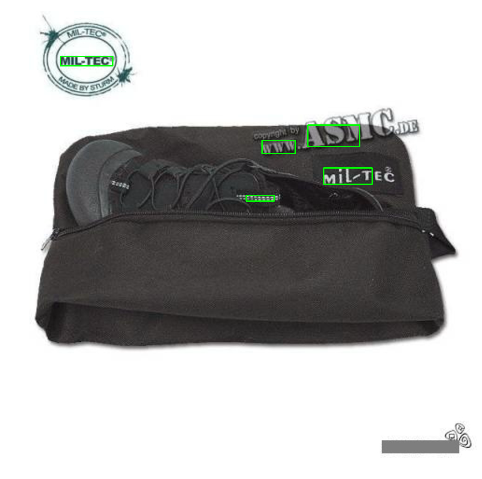

In [222]:
i = 6 #номер изображения из выборки
filename = file_list[i]
img = cv2.imread(path+filename)
raw_ans = raw_features[i][1]
plt.figure(figsize=(16,8))
plt.axis('off')
nbox = len(raw_ans)
for j in range(nbox):
    
    r1 = rec1(raw_ans[j])
    r2 = rec2(raw_ans[j])
    cv2.rectangle(img,r1,r2,(0,255,0),2)

print 'joined results of all attempts to recognise text:'
print ''.join([' '.join(j) for j in rec[i][1]])
plt.imshow(img) 

##Count number of occurences for each trigram

In [187]:
from nltk.util import ngrams
n = 3
alltrigrams = {}
toban = {}
num = -1

for i in rec:
    num += 1
    s = ''.join([''.join(j) for j in i[1]])
    trigrams = ngrams(s, n)
    for grams in trigrams:
        try:
            alltrigrams[''.join(grams)] += 1
        except:
            alltrigrams[''.join(grams)] = 1
    if y_train[num] == 1:
        trigrams = ngrams(s, n)
        for grams in trigrams:
            try:
                toban[''.join(grams)] += 1
            except:
                toban[''.join(grams)] = 1

In [193]:
probability = {}
for key in toban.keys():
    probability[key] = toban[key]/alltrigrams[key]
    
len(probability)

263807

In [235]:
banned_prob, banned_prob_test = [], []

for i in rec:
    num += 1
    s = ''.join([''.join(j) for j in i[1]])
    prob = 0
    j = 0
    trigrams = ngrams(s, n)
    for grams in trigrams:
        j += 1
        tr = ''.join(grams)
        try:
            prob += probability[tr]
        except:
            pass
    try: prob = prob/j
    except: pass
    banned_prob.append(prob)

for i in rec_test:
    num += 1
    s = ''.join([''.join(j) for j in i[1]])
    prob = 0
    j = 0
    trigrams = ngrams(s, n)
    for grams in trigrams:
        j += 1
        tr = ''.join(grams)
        try:
            prob += probability[tr]
        except:
            pass
    try: prob = prob/j
    except: pass
    banned_prob_test.append(prob)
print len(banned_prob), len(banned_prob_test)

41122 10000


## LEARNING PHASE

In [7]:
def calc_area(x):
    tmp = map(int, x.split(' '))
    return( tmp[2] * tmp[3])
    
    
def extract_features(x):
    if len(x)==0:
        return np.array([0, 0])
    else:
        a = len(x)
        b = np.mean(np.array(map(calc_area, x))) / (640*480)
        return np.array([a, b])

In [245]:
from pandas import DataFrame as df
X_train = np.array(map(lambda x: extract_features(x[1]), raw_features))
X_train = df(X_train)
X_train[2] = banned_prob
X_train = X_train.values
print X_train.shape

X_test = np.array(map(lambda x: extract_features(x[1]), raw_features_test))
X_test = df(X_test)
X_test[2] = banned_prob_test
X_test = X_test.values
print X_test.shape

joblib.dump(X_train, './features/X_train')
joblib.dump(X_test, './features/X_test')

(41122, 3)
(10000, 3)


['./features/X_test', './features/X_test_01.npy']

##You can load all extracted features here, so you won't need to calculate them in cells above

In [6]:
X_train = joblib.load('./features/X_train')
X_test = joblib.load('./features/X_test')

In [8]:
X_train[:,:2].shape

(41122, 2)

##Train SVM and make the prediction for the test images

In [10]:
from sklearn.svm import LinearSVC
model = LinearSVC()

from sklearn import cross_validation
scores = cross_validation.cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print("AUC: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

AUC: 0.812 (+/- 0.029)


In [242]:
model.fit(X_train, y_train)
pred = model.decision_function(X_test)

ans = pd.DataFrame(map(lambda x: x[:-4], file_list), columns=['Id'])
pred_norm = (pred-min(pred))/max(pred-min(pred))
ans['prediction'] = pred_norm

ans.to_csv('submission.csv', index=False)